In [11]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
import os

DATA_DIR = "/content/drive/MyDrive/Datasets/twitter-sentiment-analysis"
train_path = os.path.join(DATA_DIR, "twitter_training.csv")
val_path   = os.path.join(DATA_DIR, "twitter_validation.csv")

print("Train exists:", os.path.exists(train_path))
print("Val exists:", os.path.exists(val_path))


Train exists: True
Val exists: True


# Baseline: TF-IDF + Logistic Regression

In [13]:
import re
import pandas as pd

LABEL_MAP = {
    "Positive": 2,
    "Neutral": 1,
    "Negative": 0,
    "Irrelevant": 1,  # treat Irrelevant as Neutral
}

def clean_text(s: str) -> str:
    if s is None:
        return ""
    s = str(s)
    s = re.sub(r"http\S+|www\.\S+", " ", s)
    s = re.sub(r"@\w+", " ", s)
    s = re.sub(r"#", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def load_kaggle_csv(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)

    # handle headerless csv (common for this dataset)
    if set(df.columns) >= {0,1,2,3} or list(df.columns) == ["0","1","2","3"]:
        df.columns = ["Tweet_ID", "Entity", "Sentiment", "Tweet"]
    else:
        # best-effort rename / fallback
        needed = {"Tweet_ID", "Entity", "Sentiment", "Tweet"}
        rename = {}
        for c in df.columns:
            lc = c.lower()
            if "sent" in lc: rename[c] = "Sentiment"
            elif "tweet" in lc or "text" in lc: rename[c] = "Tweet"
            elif "entity" in lc or "topic" in lc: rename[c] = "Entity"
            elif "id" in lc: rename[c] = "Tweet_ID"
        df = df.rename(columns=rename)
        if not needed.issubset(df.columns) and df.shape[1] >= 4:
            df = df.iloc[:, :4]
            df.columns = ["Tweet_ID", "Entity", "Sentiment", "Tweet"]

    df["Tweet"] = df["Tweet"].astype(str).apply(clean_text)
    df["Entity"] = df["Entity"].astype(str).fillna("")
    df["Sentiment"] = df["Sentiment"].astype(str)

    df = df.dropna(subset=["Tweet", "Sentiment"])
    df = df[df["Tweet"].str.len() > 0]

    df["label"] = df["Sentiment"].map(LABEL_MAP)
    df = df.dropna(subset=["label"])
    df["label"] = df["label"].astype(int)
    return df

def make_input_text(df, use_entity=True):
    if use_entity:
        return ("[ENTITY] " + df["Entity"].fillna("") + " [TWEET] " + df["Tweet"].fillna("")).str.strip()
    return df["Tweet"].fillna("")


# Train + evaluate baseline + save to Drive

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import numpy as np

train_df = load_kaggle_csv(train_path)
val_df   = load_kaggle_csv(val_path)

X_train = make_input_text(train_df, use_entity=True).tolist()
y_train = train_df["label"].tolist()

X_val = make_input_text(val_df, use_entity=True).tolist()
y_val = val_df["label"].tolist()

baseline = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), max_features=200000)),
    ("clf", LogisticRegression(max_iter=2000, n_jobs=-1))
])

baseline.fit(X_train, y_train)
preds = baseline.predict(X_val)

print("=== Baseline (TF-IDF + LogisticRegression) ===")
print(classification_report(y_val, preds, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_val, preds))

ART_DIR = "/content/drive/MyDrive/Datasets/twitter_sentiment_artifacts"
os.makedirs(ART_DIR, exist_ok=True)

baseline_path = os.path.join(ART_DIR, "baseline_tfidf_lr.joblib")
joblib.dump(baseline, baseline_path)
print("Saved:", baseline_path)


=== Baseline (TF-IDF + LogisticRegression) ===
              precision    recall  f1-score   support

           0     0.9741    0.9887    0.9813       266
           1     0.9801    0.9715    0.9758       456
           2     0.9675    0.9675    0.9675       277

    accuracy                         0.9750       999
   macro avg     0.9739    0.9759    0.9749       999
weighted avg     0.9750    0.9750    0.9750       999

Confusion matrix:
 [[263   3   0]
 [  4 443   9]
 [  3   6 268]]
Saved: /content/drive/MyDrive/Datasets/twitter_sentiment_artifacts/baseline_tfidf_lr.joblib


# Train BERT (TF) + save to Drive

In [17]:
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix

MODEL_NAME = "google-bert/bert-base-uncased"
BATCH_SIZE = 16
MAX_LEN    = 128
EPOCHS     = 3
LR         = 2e-5

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def make_tf_dataset(texts, labels, shuffle=False):
    enc = tokenizer(
        texts,
        truncation=True,
        padding=True,
        max_length=MAX_LEN,
        return_tensors="tf"
    )
    ds = tf.data.Dataset.from_tensor_slices((dict(enc), labels))
    if shuffle:
        ds = ds.shuffle(20000, reshuffle_each_iteration=True)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

X_train_bert = make_input_text(train_df, use_entity=True).tolist()
y_train_bert = train_df["label"].to_numpy()

X_val_bert = make_input_text(val_df, use_entity=True).tolist()
y_val_bert = val_df["label"].to_numpy()

train_ds = make_tf_dataset(X_train_bert, y_train_bert, shuffle=True)
val_ds   = make_tf_dataset(X_val_bert, y_val_bert, shuffle=False)


bert_model = TFAutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3, from_pt=True)


optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = [tf.keras.metrics.SparseCategoricalAccuracy("accuracy")]

bert_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=1, restore_best_weights=True)
]

bert_model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=callbacks)

# Evaluate
logits = bert_model.predict(val_ds).logits
preds = logits.argmax(axis=-1)

print("=== BERT (TensorFlow) Validation Report ===")
print(classification_report(y_val_bert, preds, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_val_bert, preds))

# Save
bert_dir = os.path.join(ART_DIR, "bert_tf")
os.makedirs(bert_dir, exist_ok=True)
bert_model.save_pretrained(bert_dir)
tokenizer.save_pretrained(bert_dir)
print("Saved BERT model+tokenizer to:", bert_dir)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
4655/4655 [==============================] - 1985s 414ms/step - loss: 0.5541 - accuracy: 0.7728 - val_loss: 0.1996 - val_accuracy: 0.9279
Epoch 2/3
4655/4655 [==============================] - 1911s 411ms/step - loss: 0.2081 - accuracy: 0.9205 - val_loss: 0.0932 - val_accuracy: 0.9730
Epoch 3/3
63/63 [==============================] - 11s 135ms/step
=== BERT (TensorFlow) Validation Report ===
              precision    recall  f1-score   support

           0     0.9885    0.9737    0.9811       266
           1     0.9696    0.9803    0.9749       456
           2     0.9783    0.9747    0.9765       277

    accuracy                         0.9770       999
   macro avg     0.9788    0.9762    0.9775       999
weighted avg     0.9771    0.9770    0.9770       999

Confusion matrix:
 [[259   7   0]
 [  3 447   6]
 [  0   7 270]]
Saved BERT model+tokenizer to: /content/drive/MyDrive/Datasets/twitter_sentiment_artifacts/bert_tf


# Predict function (BERT + Baseline)

In [22]:
import numpy as np
import joblib
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

labels = ["Negative", "Neutral", "Positive"]

# Load baseline
baseline = joblib.load(os.path.join(ART_DIR, "baseline_tfidf_lr.joblib"))

# Load BERT
bert_dir = os.path.join(ART_DIR, "bert_tf")
tok = AutoTokenizer.from_pretrained(bert_dir)
mdl = TFAutoModelForSequenceClassification.from_pretrained(bert_dir)

def build_input(entity, tweet, use_entity=True):
    t = clean_text(tweet)
    e = clean_text(entity)
    return f"[ENTITY] {e} [TWEET] {t}".strip() if use_entity else t

def predict_baseline(entity, tweet):
    x = build_input(entity, tweet, True)
    pred = int(baseline.predict([x])[0])
    return labels[pred]

def predict_bert(entity, tweet):
    x = build_input(entity, tweet, True)
    enc = tok([x], truncation=True, padding=True, max_length=128, return_tensors="tf")
    logits = mdl(enc).logits.numpy()[0]
    probs = tf.nn.softmax(logits).numpy()
    pred = int(np.argmax(probs))
    return labels[pred], {labels[i]: float(probs[i]) for i in range(3)}

# Test
tests = [
    ("Apple", "This phone is amazing"),
    ("Twitter", "Worst update ever"),
    ("Google", "Update released today"),
    ("Netflix", "Good content but app is buggy"),
]

for ent, txt in tests:
    label, probs = predict_bert(ent, txt)
    print()
    print("------------------------------------")
    print(f"[{ent}] {txt} -> {label} | {probs}")


Some layers from the model checkpoint at /content/drive/MyDrive/Datasets/twitter_sentiment_artifacts/bert_tf were not used when initializing TFBertForSequenceClassification: ['dropout_75']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/Datasets/twitter_sentiment_artifacts/bert_tf.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions w


------------------------------------
[Apple] This phone is amazing -> Positive | {'Negative': 0.4052027463912964, 'Neutral': 0.02099795639514923, 'Positive': 0.5737993121147156}

------------------------------------
[Twitter] Worst update ever -> Negative | {'Negative': 0.999329686164856, 'Neutral': 0.0004925892571918666, 'Positive': 0.00017779179324861616}

------------------------------------
[Google] Update released today -> Neutral | {'Negative': 0.4180663228034973, 'Neutral': 0.47335511445999146, 'Positive': 0.108578622341156}

------------------------------------
[Netflix] Good content but app is buggy -> Neutral | {'Negative': 0.36602362990379333, 'Neutral': 0.6326035857200623, 'Positive': 0.001372789847664535}


Mounted at /content/drive
Validation samples: 999
Label distribution: [266 456 277]


TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some layers from the model checkpoint at /content/drive/MyDrive/Datasets/twitter_sentiment_artifacts/bert_tf were not used when initializing TFBertForSequenceClassification: ['dropout_75']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/Datasets/twitter_sentiment_art


=== Confusion Matrix: Baseline (TF-IDF + LR) ===
 [[263   3   0]
 [  4 443   9]
 [  3   6 268]]

=== Confusion Matrix: BERT ===
 [[259   7   0]
 [  3 447   6]
 [  0   7 270]]


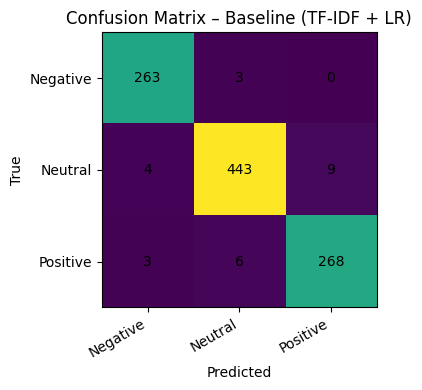

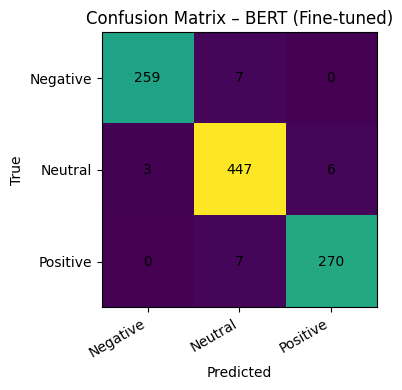


=== Comparison Table ===


,Accuracy,Precision (macro),Recall (macro),F1-score (macro)
Baseline (TF-IDF + LR),0.974975,0.973891,0.975907,0.974874
BERT (Fine-tuned),0.976977,0.978814,0.976226,0.977490


✅ Saved comparison table to: /content/drive/MyDrive/Datasets/twitter_sentiment_artifacts/model_comparison.csv


In [1]:
# ========= Mount Drive (if not mounted) =========
from google.colab import drive
drive.mount('/content/drive')

import os, re
import numpy as np
import pandas as pd
import joblib
import tensorflow as tf
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification


# ========= Paths (yours) =========
DATA_DIR = "/content/drive/MyDrive/Datasets/twitter-sentiment-analysis"
ART_DIR  = "/content/drive/MyDrive/Datasets/twitter_sentiment_artifacts"

VAL_CSV = os.path.join(DATA_DIR, "twitter_validation.csv")
BASELINE_PATH = os.path.join(ART_DIR, "baseline_tfidf_lr.joblib")
BERT_DIR = os.path.join(ART_DIR, "bert_tf")


# ========= Same preprocessing as training =========
LABEL_MAP = {"Positive": 2, "Neutral": 1, "Negative": 0, "Irrelevant": 1}
CLASS_NAMES = ["Negative", "Neutral", "Positive"]

def clean_text(s: str) -> str:
    if s is None:
        return ""
    s = str(s)
    s = re.sub(r"http\S+|www\.\S+", " ", s)
    s = re.sub(r"@\w+", " ", s)
    s = re.sub(r"#", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def load_kaggle_csv(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)

    # headerless support
    if set(df.columns) >= {0,1,2,3} or list(df.columns) == ["0","1","2","3"]:
        df.columns = ["Tweet_ID","Entity","Sentiment","Tweet"]
    else:
        # fallback: first 4 cols
        if df.shape[1] >= 4:
            df = df.iloc[:, :4]
            df.columns = ["Tweet_ID","Entity","Sentiment","Tweet"]

    df["Tweet"] = df["Tweet"].astype(str).apply(clean_text)
    df["Entity"] = df["Entity"].astype(str).fillna("")
    df["Sentiment"] = df["Sentiment"].astype(str)

    df["label"] = df["Sentiment"].map(LABEL_MAP)
    df = df.dropna(subset=["label"])
    df["label"] = df["label"].astype(int)
    df = df[df["Tweet"].str.len() > 0]
    return df

def make_input_text(df, use_entity=True):
    if use_entity:
        return ("[ENTITY] " + df["Entity"].fillna("") + " [TWEET] " + df["Tweet"].fillna("")).str.strip()
    return df["Tweet"].fillna("")


# ========= Load validation data =========
val_df = load_kaggle_csv(VAL_CSV)
X_val = make_input_text(val_df, use_entity=True).tolist()
y_val = val_df["label"].to_numpy()

print("Validation samples:", len(X_val))
print("Label distribution:", np.bincount(y_val))


# ========= Load models =========
baseline = joblib.load(BASELINE_PATH)

tokenizer = AutoTokenizer.from_pretrained(BERT_DIR)
bert_model = TFAutoModelForSequenceClassification.from_pretrained(BERT_DIR)


# ========= Predict: Baseline =========
preds_baseline = baseline.predict(X_val)

# ========= Predict: BERT =========
enc = tokenizer(X_val, truncation=True, padding=True, max_length=128, return_tensors="tf")
logits = bert_model(enc).logits.numpy()
preds_bert = np.argmax(logits, axis=-1)


# ========= Confusion Matrices (printed) =========
cm_baseline = confusion_matrix(y_val, preds_baseline)
cm_bert = confusion_matrix(y_val, preds_bert)

print("\n=== Confusion Matrix: Baseline (TF-IDF + LR) ===\n", cm_baseline)
print("\n=== Confusion Matrix: BERT ===\n", cm_bert)


# ========= Plot Confusion Matrices (matplotlib only) =========
def plot_cm(cm, title):
    plt.figure(figsize=(5,4))
    plt.imshow(cm)  # no fixed colors requested; default colormap
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks(range(len(CLASS_NAMES)), CLASS_NAMES, rotation=30, ha="right")
    plt.yticks(range(len(CLASS_NAMES)), CLASS_NAMES)

    # annotate
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i, j]), ha="center", va="center")

    plt.tight_layout()
    plt.show()

plot_cm(cm_baseline, "Confusion Matrix – Baseline (TF-IDF + LR)")
plot_cm(cm_bert, "Confusion Matrix – BERT (Fine-tuned)")


# ========= Results comparison table =========
def metrics(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision (macro)": precision_score(y_true, y_pred, average="macro"),
        "Recall (macro)": recall_score(y_true, y_pred, average="macro"),
        "F1-score (macro)": f1_score(y_true, y_pred, average="macro"),
    }

baseline_metrics = metrics(y_val, preds_baseline)
bert_metrics = metrics(y_val, preds_bert)

results_df = pd.DataFrame(
    [baseline_metrics, bert_metrics],
    index=["Baseline (TF-IDF + LR)", "BERT (Fine-tuned)"]
)

print("\n=== Comparison Table ===")
display(results_df)

# optional save
out_csv = os.path.join(ART_DIR, "model_comparison.csv")
results_df.to_csv(out_csv)
print("✅ Saved comparison table to:", out_csv)
